# Egg-box Likelihood with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = (2. + \prod_i cos(\frac{\theta_i}{2})))^5$

and

$P(x) = \mathcal{U}[x \mid 0, 10]$.


In [1]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jax import config

# Needed because otherwise likelihoods hit numerical plateau
config.update("jax_enable_x64", True)

from jaxns import NestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:


ndim = 2


def log_likelihood(theta):
    return jnp.power(2. + jnp.prod(jnp.cos(0.5 * theta)), 5)


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros(ndim), high=jnp.pi * 10 * jnp.ones(ndim)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


True log(Z)=236.0483738381629


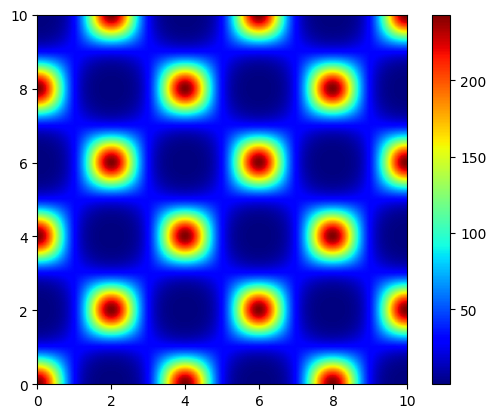

In [3]:
u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(lik, origin='lower', extent=(0., 10., 0., 10.), cmap='jet')
plt.colorbar()
plt.show()

In [4]:


# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(model=model, max_samples=1e5, difficult_model=True)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:61: UserWarning: Expected integer type, got bool, at public.py:173 in to_results -> sharded_static.py:475 in _to_results -> mixed_precision.py:105 in cast_to_count -> mixed_precision.py:67 in _cast_integer_to -> tree.py:61 in map -> tree_util.py:321 in tree_map -> tree_util.py:321 in <genexpr> -> mixed_precision.py:61 in conditional_cast.
  warnings.warn(f"Expected integer type, got {x.dtype}, {get_grandparent_info()}.")


In [5]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 441896
samples: 2700
phantom samples: 0
likelihood evals / sample: 163.7
phantom fraction (%): 0.0%
--------
logZ=236.02 +- 0.21
max(logL)=243.0
H=-6.06
ESS=258
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 16.9 +- 8.9 | 6.2 / 18.8 / 31.2 | 0.0 | 0.0
theta[1]: 15.0 +- 10.0 | 0.0 / 13.0 / 31.0 | 13.0 | 13.0
--------


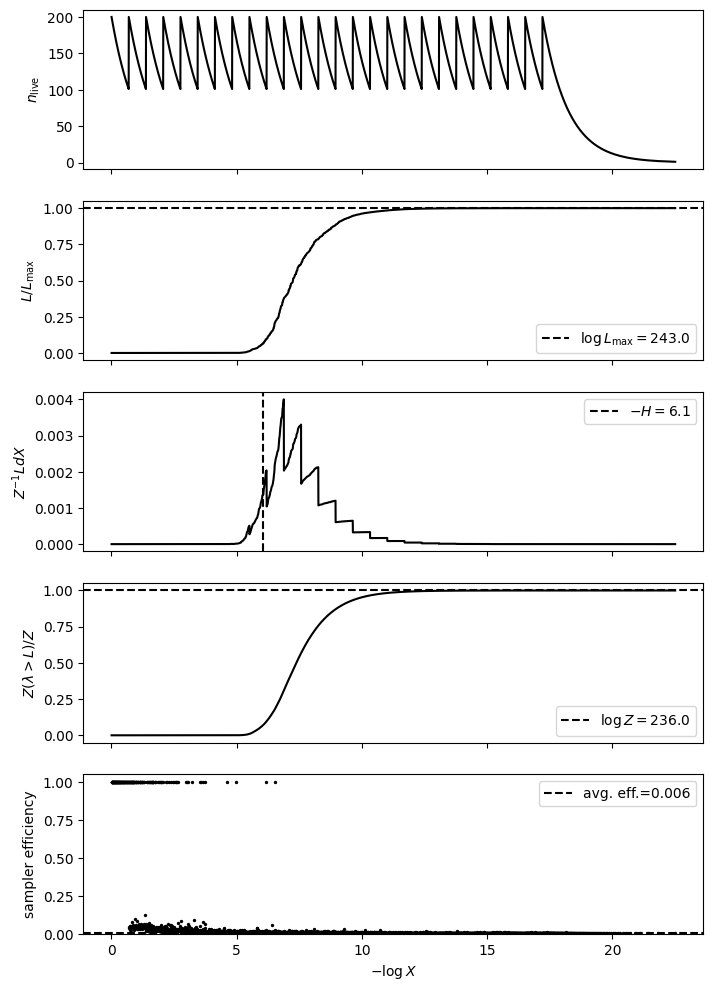

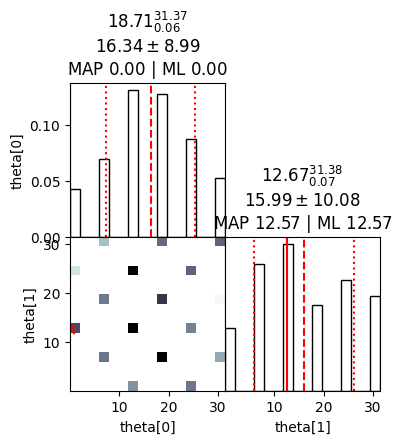

In [6]:

# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)